In [1]:
import html
import re

import tensorflow_datasets as tfds

class SubalphabetSubwordTextEncoder:
    HTML_ESCAPE_PATTERN = re.compile('&(((#\d+)|([A-Za-z]+));&?)+')
    SPECIAL_CHAR = 'X'

    def __init__(self, subalphabet, vocab_list=None):
        self._subword_text_encoder = tfds.features.text.SubwordTextEncoder(vocab_list)
        self._subalphabet = subalphabet

    def encode(self, s):
        subword_max_code = len(self.subwords)
        codes = self._build_encoding_dict(self._subalphabet)
        preprocessed_string = self.preprocess_string(s)

        result = []
        unicode_buffer = bytearray()
        for id in self._subword_text_encoder.encode(preprocessed_string):
            if id <= subword_max_code:
                result.append(id)
            else:
                unicode_buffer.append(id - subword_max_code - 1)
                try:
                    id = ord(unicode_buffer.decode())
                    result.append(subword_max_code + codes[id] + 1)
                    unicode_buffer = bytearray()
                except UnicodeDecodeError:
                    pass
        return result

    def decode(self, ids):
        subword_max_code = len(self.subwords)

        processed_ids = []
        for id in ids:
            if id <= subword_max_code:
                processed_ids.append(id)
            else:
                char = self._subalphabet[id - subword_max_code - 1].encode()
                processed_ids += [codepoint + subword_max_code + 1 for codepoint in char]

        return self._subword_text_encoder.decode(processed_ids)
    
    @classmethod
    def build_from_corpus(cls, corpus_generator, subalphabet_size, target_vocab_size, max_subword_length=20, max_corpus_chars=None, reserved_tokens=None):
        simplified_strings = []
        char_counts = defaultdict(lambda: 0)

        for string in corpus_generator:
            simplified_string = cls._unescape_string(string.lower())
            simplified_strings.append(simplified_string)
            for char in simplified_string:
                char_counts[char] += 1

        sorted_char_counts = sorted(char_counts.items(), key = lambda item: item[1], reverse = True)
        chars = [char for char, char_count in sorted_char_counts[:subalphabet_size - 1]]
        chars = list(reversed(chars)) # We reverse the chars so that the most common ones are last
        chars = cls._ensure_special_character_presence(chars)

        def simplified_corpus():
            for string in simplified_strings:
                yield cls._compact_string(chars, string)

        subword_text_encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(simplified_corpus(), target_vocab_size + 256 - subalphabet_size)
        
        return cls(chars, subword_text_encoder.subwords)
    
    @classmethod
    def load_from_file(cls, filename_prefix):
        subword_text_encoder = tfds.features.text.SubwordTextEncoder.load_from_file(filename_prefix)
        with open(filename_prefix + '.subalphabet', 'rb') as text_file:
            subalphabet = ['\0', cls.SPECIAL_CHAR] + text_file.read().decode().split('\0')

        return cls(subalphabet, subword_text_encoder.subwords)
    
    def save_to_file(self, filename_prefix):
        self._subword_text_encoder.save_to_file(filename_prefix)
        with open(filename_prefix + '.subalphabet', 'wb') as text_file:
            text_file.write('\0'.join(self._subalphabet[2:]).encode())

    def preprocess_string(self, string):
        return self._compact_string(self._subalphabet, self._unescape_string(string.lower()))

    @property
    def vocab_size(self):
        return self._subword_text_encoder.vocab_size - 256 + len(self._subalphabet)
    
    @property
    def subwords(self):
        return self._subword_text_encoder.subwords

    @classmethod
    def _ensure_special_character_presence(cls, chars):
        if '\0' in chars:
            chars = [char for char in chars if char != '\0']
        else:
            chars = chars[1:]

        return ['\0', cls.SPECIAL_CHAR] + chars
    
    @classmethod
    def _unescape_html_symbol(cls, escaped):
        escaped_symbols = escaped.group(0).split(';')
        escaped_symbols = escaped_symbols[:-1] # strip the last string empty string
        escaped_symbols = (escaped_symbol + ';' for escaped_symbol in escaped_symbols)
        result = ''

        for escaped_symbol in escaped_symbols:
            code = escaped_symbol[1:] if escaped_symbol[0] == '&' else escaped_symbol

            if code[0] == '#':
                result += chr(int(code[1:-1]))
            elif code in html.entities.html5:
                result += html.entities.html5[code]
            else:
                result += escaped_symbol

        return result
    
    @classmethod
    def _unescape_string(cls, string):
        return cls.HTML_ESCAPE_PATTERN.sub(cls._unescape_html_symbol, string)
    
    @classmethod
    def _compact_string(cls, chars, string):
        if len(string) == 0:
            return string
        else:
            compacted_string = string[0]

            for char in string[1:]:
                if char not in chars or char == cls.SPECIAL_CHAR:
                    if compacted_string[-1] != cls.SPECIAL_CHAR:
                        compacted_string += cls.SPECIAL_CHAR
                else:
                    compacted_string += char

            return compacted_string
    
    @classmethod
    def _build_encoding_dict(cls, chars):
        return {ord(char): index for index, char in enumerate(chars)}

In [2]:
encoder = SubalphabetSubwordTextEncoder.load_from_file('72_256')

In [3]:
import itertools
import math
import os

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from checkpointing import checkpointable

physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)

In [4]:
TYPE=np.int16

class Articles:
    EMPTY_ARTICLE = np.array([], dtype=TYPE) # used for padding
    
    def __init__(self, path):
        with open(path, 'rb') as text_file:
            data = text_file.read().decode()

        self.articles = sorted(set(data.split('\0')), key=len)
        self._encoded_articles = None

    @property
    def encoded_articles(self):
        if self._encoded_articles == None:
            self._encoded_articles = [np.array(encoder.encode(article), dtype=TYPE) for article in self.articles]
        
        return self._encoded_articles

    def articles_generator(self, batch_size = 1, start = 0, end = None):
        end = end or len(self.articles)

        for _ in range(batch_size - ((end - start - 1) % batch_size + 1)):
            yield self.EMPTY_ARTICLE

        for article in itertools.islice(self.encoded_articles, start, end):
            yield article

    def subbatch_generator(self, batch_size, batch_length, start = 0, end = None):
        end = end or len(self.articles)

        dataset = tf.data.Dataset.from_generator(self.articles_generator, args=(batch_size, start, end), output_types=TYPE)
        dataset = dataset.padded_batch(batch_size, padded_shapes=([None]), drop_remainder=True)
        dataset = dataset.shuffle(100)

        for batch in dataset.as_numpy_iterator():
            remaining = batch
            while remaining.shape[1] > batch_length + 1:
                yield remaining[:, :batch_length + 1]
                remaining = remaining[:, batch_length:]

            if remaining.shape[1] == batch_length + 1:
                yield remaining
                yield np.zeros((batch_size, batch_length + 1), dtype=TYPE)
            else:
                yield np.hstack([remaining, np.zeros([batch_size, batch_length - remaining.shape[1] + 1])])

    def steps(self, batch_size, batch_length):
        articles = self.articles_generator(batch_size, batch_length)
        return sum(math.ceil(len(article) / batch_length + 1) for i, article in enumerate(articles) if (i + 1) % batch_size == 0)

    def dataset(self, batch_size, batch_length, start = 0, end = None):
        end = end or len(self.articles)

        dataset = tf.data.Dataset.from_generator(self.subbatch_generator, args=(batch_size, batch_length, start, end), output_types=TYPE, output_shapes=(batch_size, batch_length + 1))
        return dataset.map(lambda batch: (batch[:, :-1], batch[:, 1:]))

In [5]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits)

def average_final_batch_ratio(true_labels, predictions):
    return 0 ** tf.math.abs(true_labels[-1, -1])

class ModelStateResetter(tf.keras.callbacks.Callback):
    def __init__(self):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        self.last_final_batch_count = 0
        
    def on_batch_end(self, batch, logs={}):
        average_final_batch_ratio = logs.get('average_final_batch_ratio', 0)
        final_batch_count = int(round(average_final_batch_ratio * (batch + 1)))
        is_final = final_batch_count - self.last_final_batch_count
        self.last_final_batch_count = final_batch_count
        
        if is_final:
            self.model.reset_states()

class Model:
    def __init__(self, articles, checkpoint_dir, vocab_size, embedding_dim, rnn_units):
        self._articles = articles
        self._batch_size = None
        self._batched_item_length = None
        self._training_model = None
        self._predicting_model = None
        self._vocab_size = vocab_size
        self._embedding_dim = embedding_dim
        self._rnn_units = rnn_units

        self._checkpoint_dir = checkpoint_dir
        self._checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}") # Name of the checkpoint files

    def training_model(self, batch_size, batched_item_length):
        if self._training_model == None or batch_size != self._batch_size or batched_item_length != self._batched_item_length:
            self._batch_size = batch_size
            self._batched_item_length = batched_item_length
            self._training_model = tf.keras.Sequential([
                checkpointable(tf.keras.layers.Masking)(mask_value=0, batch_input_shape=[batch_size, batched_item_length]),
                checkpointable(tf.keras.layers.Embedding)(self._vocab_size, self._embedding_dim),
                checkpointable(tf.keras.layers.GRU)(self._rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
                checkpointable(tf.keras.layers.GRU)(self._rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
                checkpointable(tf.keras.layers.Dense)(self._vocab_size, activation='softmax'),
            ])

            if os.path.isdir(self._checkpoint_dir):
                self._training_model.load_weights(tf.train.latest_checkpoint(self._checkpoint_dir))

            self._training_model.compile(optimizer='adam', loss=loss, metrics=[average_final_batch_ratio])
            self._predicting_model = None
        
        return self._training_model

    @property
    def callbacks(self):
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self._checkpoint_prefix, save_weights_only=True)
        model_state_resetter_callback = ModelStateResetter()
        
        return [checkpoint_callback, model_state_resetter_callback]
    
    def train(self, batch_size, batched_item_length, epochs=1):
        dataset = self._articles.dataset(batch_size, batched_item_length)

        model = self.training_model(batch_size, batched_item_length)

        model.fit(dataset, epochs=epochs, callbacks=self.callbacks)
    
    @property
    def predicting_model(self):
        if self._predicting_model == None:
            self._predicting_model = tf.keras.Sequential([
                checkpointable(tf.keras.layers.Masking)(mask_value=0, batch_input_shape=[1, 1]),
                checkpointable(tf.keras.layers.Embedding)(self._vocab_size, self._embedding_dim),
                checkpointable(tf.keras.layers.GRU)(self._rnn_units, stateful=True, return_sequences=True),
                checkpointable(tf.keras.layers.GRU)(self._rnn_units, stateful=True, return_sequences=True),
                checkpointable(tf.keras.layers.Dense)(self._vocab_size, activation='softmax'),
            ])
            
            self._predicting_model.load_weights(tf.train.latest_checkpoint(self._checkpoint_dir))
            self._training_model = None
        
        return self._predicting_model
    
    def predict(self, input_eval):
        return self.predicting_model(input_eval)

In [6]:
articles = Articles('page_revisions_text_with_title')

In [7]:
model = Model(articles, './training_checkpoints-33', vocab_size = encoder.vocab_size, embedding_dim=128, rnn_units=1280)

In [8]:
model.training_model(384, 128).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (384, 128)                0         
_________________________________________________________________
embedding (Embedding)        (384, 128, 128)           32640     
_________________________________________________________________
gru (GRU)                    (384, 128, 1280)          5414400   
_________________________________________________________________
gru_1 (GRU)                  (384, 128, 1280)          9838080   
_________________________________________________________________
dense (Dense)                (384, 128, 255)           326655    
Total params: 15,611,775
Trainable params: 15,611,775
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.train(384, 128, epochs=10)

Epoch 1/10
17559/17559 [==============================] - 14929s 850ms/step - loss: 1.8252 - average_final_batch_ratio: 0.2253
Epoch 2/10
17559/17559 [==============================] - 13384s 762ms/step - loss: 1.1359 - average_final_batch_ratio: 0.2253
Epoch 3/10
17559/17559 [==============================] - 13398s 763ms/step - loss: 1.0749 - average_final_batch_ratio: 0.2253
Epoch 4/10
   87/17559 [..............................] - ETA: 3:43:27 - loss: 0.3599 - average_final_batch_ratio: 1.0000

KeyboardInterrupt: 

Прекъснахме обучението, за да проверим резултата до тук

In [11]:
import ctypes

class Huffman:
    huffman = ctypes.CDLL('x64/Release/huffman')
    
    huffman.create_tree.restype = ctypes.c_void_p
    huffman.destroy_tree.restype = None
    huffman.load_weights.restype = None
    huffman.create_code_string.restype = ctypes.c_char_p
    
    def __init__(self, category_count):
        self.category_count = category_count
        self.tree = ctypes.c_void_p(self.huffman.create_tree(category_count))

    def __del__(self):
        self.huffman.destroy_tree(self.tree)
        
    def load_weights(self, weights):
        self.huffman.load_weights(self.tree, weights.ctypes.data_as(ctypes.POINTER(ctypes.c_float)))
    
    def get_code_length(self, category):
        return self.huffman.get_code_length(self.tree, category)

    def get_code_zero_count(self, category):
        return self.huffman.get_code_zero_count(self.tree, category)
    
    def archive_size(self, model, text):
        archived_size = 0
        input_eval = np.array([[text[0]]], dtype=TYPE)

        model.predicting_model.reset_states()

        for byte in text[1:]:
            predictions = model.predict(input_eval)
            predictions = tf.squeeze(predictions, 0) # remove the batch dimension

            weights = predictions[0].numpy()
            self.load_weights(weights)
            archived_size += self.get_code_length(byte.item())

            input_eval = tf.expand_dims([byte], 0)

        return archived_size

In [13]:
total_raw = 0
total_compressed = 0

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 10000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        total_raw += len(article) * 8
        total_compressed += huffman.archive_size(model, encoded_article)
        print('Article %d:\tLength: %d\tAvg Compression: %f' % (index, len(article), total_compressed/total_raw))

Article 10000:	Length: 35	Avg Compression: 0.225000
Article 20000:	Length: 41	Avg Compression: 0.175987
Article 30000:	Length: 46	Avg Compression: 0.168033
Article 40000:	Length: 51	Avg Compression: 0.171965
Article 50000:	Length: 57	Avg Compression: 0.165217
Article 60000:	Length: 67	Avg Compression: 0.166667
Article 70000:	Length: 85	Avg Compression: 0.169175
Article 80000:	Length: 185	Avg Compression: 0.177910
Article 90000:	Length: 467	Avg Compression: 0.209260
Article 100000:	Length: 820	Avg Compression: 0.209614
Article 110000:	Length: 1144	Avg Compression: 0.204428
Article 120000:	Length: 1587	Avg Compression: 0.214858
Article 130000:	Length: 2096	Avg Compression: 0.219597
Article 140000:	Length: 2541	Avg Compression: 0.184504
Article 150000:	Length: 2648	Avg Compression: 0.166386
Article 160000:	Length: 2769	Avg Compression: 0.153340
Article 170000:	Length: 3065	Avg Compression: 0.169354
Article 180000:	Length: 3582	Avg Compression: 0.163693
Article 190000:	Length: 4281	Avg Com

In [14]:
model.train(384, 128, epochs=7)

Epoch 1/7
17559/17559 [==============================] - 13489s 768ms/step - loss: 1.0375 - average_final_batch_ratio: 0.2253
Epoch 2/7
17559/17559 [==============================] - 13509s 769ms/step - loss: 1.0280 - average_final_batch_ratio: 0.2253
Epoch 3/7
    1/17559 [..............................] - ETA: 6:52:54

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run Identity: GPU sync failed [Op:Identity]

In [13]:
total_raw = 0
total_compressed = 0

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 10000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        total_raw += len(article) * 8
        total_compressed += huffman.archive_size(model, encoded_article)
        print('Article %d:\tLength: %d\tAvg Compression: %f' % (index, len(article), total_compressed/total_raw))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CE4DECE7C8> and <tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE58700C48>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE58700C48> and <tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE8286F288>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE8286F288> and <tensorflow.python.keras.layers.core.Dense object at 0x000001CE59B8FF48>).
Article 10000:	Length: 35	Avg Compression: 0.217857
Article 20000:	Length: 41	Avg Compression: 0.207237
Article 30000:	Length: 46	Avg Compression: 0.207992
Article 40000:	Length: 51	Avg Compression: 0.232659
Article 50000:	Length: 57	Avg Compression: 0.240217
Article 60000:	Length: 67	Avg Compression: 0.227273
Article 70000:	Length: 8

In [14]:
model.train(384, 128, epochs=5)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CE384AF048> and <tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE3485F208>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE3485F208> and <tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE89AD6908>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.GRU object at 0x000001CE89AD6908> and <tensorflow.python.keras.layers.core.Dense object at 0x000001CE89AD6548>).
Epoch 1/5
17561/17561 [==============================] - 13477s 767ms/step - loss: 1.1719 - average_final_batch_ratio: 0.2216
Epoch 2/5
17561/17561 [==============================] - 13276s 756ms/step - loss: 1.0491 - average_final_batch_ratio: 0.2216
Epoch 3/5
17561/17561 [==============================] - 13341s 760ms/step - loss: 1

In [15]:
total_raw = 0
total_compressed = 0

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 10000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        total_raw += len(article) * 8
        total_compressed += huffman.archive_size(model, encoded_article)
        print('Article %d:\tLength: %d\tAvg Compression: %f' % (index, len(article), total_compressed/total_raw))

Article 10000:	Length: 35	Avg Compression: 0.400000
Article 20000:	Length: 41	Avg Compression: 0.399671
Article 30000:	Length: 46	Avg Compression: 0.371926
Article 40000:	Length: 51	Avg Compression: 0.372832
Article 50000:	Length: 57	Avg Compression: 0.395109
Article 60000:	Length: 67	Avg Compression: 0.399411
Article 70000:	Length: 85	Avg Compression: 0.389725
Article 80000:	Length: 185	Avg Compression: 0.382055
Article 90000:	Length: 467	Avg Compression: 0.340788
Article 100000:	Length: 820	Avg Compression: 0.310545
Article 110000:	Length: 1144	Avg Compression: 0.320297
Article 120000:	Length: 1587	Avg Compression: 0.305943
Article 130000:	Length: 2096	Avg Compression: 0.308150
Article 140000:	Length: 2541	Avg Compression: 0.253199
Article 150000:	Length: 2648	Avg Compression: 0.224000
Article 160000:	Length: 2746	Avg Compression: 0.244116
Article 170000:	Length: 2871	Avg Compression: 0.272166
Article 180000:	Length: 3568	Avg Compression: 0.289272
Article 190000:	Length: 4265	Avg Com

In [16]:
model.train(384, 128, epochs=2)

Epoch 1/2
17561/17561 [==============================] - 13329s 759ms/step - loss: 1.4073 - average_final_batch_ratio: 0.2216
Epoch 2/2
17561/17561 [==============================] - 13243s 754ms/step - loss: 1.3938 - average_final_batch_ratio: 0.2216


In [17]:
total_raw = 0
total_compressed = 0

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 10000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        total_raw += len(article) * 8
        total_compressed += huffman.archive_size(model, encoded_article)
        print('Article %d:\tLength: %d\tAvg Compression: %f' % (index, len(article), total_compressed/total_raw))

Article 10000:	Length: 35	Avg Compression: 0.317857
Article 20000:	Length: 41	Avg Compression: 0.302632
Article 30000:	Length: 46	Avg Compression: 0.284836
Article 40000:	Length: 51	Avg Compression: 0.306358
Article 50000:	Length: 57	Avg Compression: 0.320652
Article 60000:	Length: 67	Avg Compression: 0.311448
Article 70000:	Length: 85	Avg Compression: 0.307592
Article 80000:	Length: 185	Avg Compression: 0.309083
Article 90000:	Length: 467	Avg Compression: 0.280343
Article 100000:	Length: 820	Avg Compression: 0.254989
Article 110000:	Length: 1144	Avg Compression: 0.267345
Article 120000:	Length: 1587	Avg Compression: 0.260823
Article 130000:	Length: 2096	Avg Compression: 0.262928
Article 140000:	Length: 2541	Avg Compression: 0.218120
Article 150000:	Length: 2648	Avg Compression: 0.193134
Article 160000:	Length: 2746	Avg Compression: 0.211284
Article 170000:	Length: 2871	Avg Compression: 0.239099
Article 180000:	Length: 3568	Avg Compression: 0.255598
Article 190000:	Length: 4265	Avg Com

In [18]:
model.train(384, 128, epochs=2)

Epoch 1/2
17561/17561 [==============================] - 13298s 757ms/step - loss: 1.2863 - average_final_batch_ratio: 0.2216
Epoch 2/2
17561/17561 [==============================] - 13107s 746ms/step - loss: 1.2500 - average_final_batch_ratio: 0.2216


In [19]:
total_raw = 0
total_compressed = 0

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 5000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        total_raw += len(article) * 8
        total_compressed += huffman.archive_size(model, encoded_article)
        print('Article %d:\tLength: %d\tAvg Compression: %f' % (index, len(article), total_compressed/total_raw))

Article 5000:	Length: 32	Avg Compression: 0.312500
Article 10000:	Length: 35	Avg Compression: 0.276119
Article 15000:	Length: 38	Avg Compression: 0.294048
Article 20000:	Length: 41	Avg Compression: 0.267979
Article 25000:	Length: 43	Avg Compression: 0.271825
Article 30000:	Length: 46	Avg Compression: 0.260638
Article 35000:	Length: 48	Avg Compression: 0.274735
Article 40000:	Length: 51	Avg Compression: 0.281063
Article 45000:	Length: 54	Avg Compression: 0.280606
Article 50000:	Length: 57	Avg Compression: 0.283427
Article 55000:	Length: 61	Avg Compression: 0.272727
Article 60000:	Length: 67	Avg Compression: 0.268979
Article 65000:	Length: 74	Avg Compression: 0.276275
Article 70000:	Length: 85	Avg Compression: 0.275102
Article 75000:	Length: 108	Avg Compression: 0.283036
Article 80000:	Length: 185	Avg Compression: 0.282439
Article 85000:	Length: 292	Avg Compression: 0.258827
Article 90000:	Length: 467	Avg Compression: 0.253293
Article 95000:	Length: 637	Avg Compression: 0.263992
Article 

In [62]:
total_raw = 0
total_compressed = 0

def information_entropy(model, text):
    entropy = 0
    input_eval = np.array([[text[0]]], dtype=TYPE)

    model.predicting_model.reset_states()

    for byte in text[1:]:
        predictions = model.predict(input_eval)
        predictions = tf.squeeze(predictions, 0) # remove the batch dimension

        px = predictions[0, byte.item()].numpy()
        entropy -= math.log2(px)
        
        input_eval = tf.expand_dims([byte], 0)
        
    return entropy

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 1000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        #total_raw += len(article) * 8
        entropy = information_entropy(model, encoded_article)
        print('Article %d:\tLength: %d\tEntropy: %f, Compression: %f' % (
            index,
            len(encoded_article),
            entropy, entropy / (len(article) * 8))
        )

Article 1000:	Length: 18	Entropy: 72.172832, Compression: 0.334133
Article 2000:	Length: 24	Entropy: 71.550512, Compression: 0.308407
Article 3000:	Length: 22	Entropy: 60.982851, Compression: 0.254095
Article 4000:	Length: 20	Entropy: 119.177123, Compression: 0.480553
Article 5000:	Length: 21	Entropy: 88.774634, Compression: 0.346776
Article 6000:	Length: 18	Entropy: 68.004441, Compression: 0.265642
Article 7000:	Length: 20	Entropy: 79.379912, Compression: 0.300681
Article 8000:	Length: 21	Entropy: 94.901665, Compression: 0.348903
Article 9000:	Length: 19	Entropy: 63.467661, Compression: 0.233337
Article 10000:	Length: 24	Entropy: 60.501720, Compression: 0.216078
Article 11000:	Length: 20	Entropy: 82.704572, Compression: 0.287169
Article 12000:	Length: 25	Entropy: 80.247285, Compression: 0.278636
Article 13000:	Length: 26	Entropy: 106.932477, Compression: 0.361258
Article 14000:	Length: 22	Entropy: 72.892050, Compression: 0.239776
Article 15000:	Length: 28	Entropy: 96.386192, Compressi

Article 120000:	Length: 1098	Entropy: 2491.864352, Compression: 0.196272
Article 121000:	Length: 986	Entropy: 3931.361511, Compression: 0.300931
Article 122000:	Length: 992	Entropy: 3529.465223, Compression: 0.262765
Article 123000:	Length: 1000	Entropy: 3453.325366, Compression: 0.253921
Article 124000:	Length: 958	Entropy: 3032.591963, Compression: 0.214287
Article 125000:	Length: 1023	Entropy: 3712.768558, Compression: 0.255841
Article 126000:	Length: 1078	Entropy: 4052.444891, Compression: 0.269588
Article 127000:	Length: 1099	Entropy: 4288.789123, Compression: 0.277484
Article 128000:	Length: 1060	Entropy: 3854.072015, Compression: 0.242455
Article 129000:	Length: 1188	Entropy: 3934.100112, Compression: 0.240706
Article 130000:	Length: 1150	Entropy: 4167.638633, Compression: 0.248547
Article 131000:	Length: 1454	Entropy: 5379.546020, Compression: 0.312619
Article 132000:	Length: 1360	Entropy: 5297.139555, Compression: 0.299748
Article 133000:	Length: 1237	Entropy: 4113.120355, Com

Article 232000:	Length: 8970	Entropy: 33988.554175, Compression: 0.271596
Article 233000:	Length: 9268	Entropy: 31346.235486, Compression: 0.234221
Article 234000:	Length: 9918	Entropy: 39327.029597, Compression: 0.275770
Article 235000:	Length: 10708	Entropy: 39488.790058, Compression: 0.260370
Article 236000:	Length: 11397	Entropy: 42813.683181, Compression: 0.261531
Article 237000:	Length: 11889	Entropy: 40279.340887, Compression: 0.226911
Article 238000:	Length: 13270	Entropy: 52261.628421, Compression: 0.272537
Article 239000:	Length: 13958	Entropy: 52995.296967, Compression: 0.262686
Article 240000:	Length: 16497	Entropy: 59139.841095, Compression: 0.249434
Article 241000:	Length: 19803	Entropy: 71368.795870, Compression: 0.262934
Article 242000:	Length: 22883	Entropy: 83768.062640, Compression: 0.253584
Article 243000:	Length: 31801	Entropy: 132891.660840, Compression: 0.287973


In [68]:
all_articles = list(articles.articles_generator(1))

In [69]:
print(encoder.decode(all_articles[140000]))

=edwards township, minnesota=
'''edwards township''' is a township located in [[kandiyohi county, minnesota]].  as of the [[2000]] census, the township had a total population of 304.

== geography ==
according to the [[united states census bureau]], the township has a total area of 92.6 [[square kilometer|km&sup2;]] (35.7 [[square mile|mi&sup2;]]).  91.6 km&sup2; (35.4 mi&sup2;) of it is land and 1.0 km&sup2; (0.4 mi&sup2;) of it is water.  the total area is 1.04% water.

== demographics ==
as of the [[census]][[geographic references#2|<sup>2</sup>]] of [[2000]], there are 304 people, 101 households, and 84 families residing in the township.  the [[population density]] is 3.3/km&sup2; (8.6/mi&sup2;).  there are 106 housing units at an average density of 1.2/km&sup2; (3.0/mi&sup2;).  the racial makeup of the township is 97.37% [[white (u.s. census)|white]], 1.64% [[african american (u.s. census)|african american]], 0.33% [[native american (u.s. census)|native american]], 0.00% [[asian (

In [70]:
print(encoder.decode(all_articles[150000]))

=tolna, north dakota=
'''tolna''' is a city located in [[nelson county, north dakota]].  as of the [[2000]] census, the city had a total population of 202.

== geography ==
[[image:ndmap-doton-tolna.png|right|location of tolna, north dakota]]
tolna is located at 47°49'36" north, 98°26'21" west (47.826639, -98.439236){{gr|1}}.

according to the [[united states census bureau]], the city has a total area of 2.0 [[square kilometer|km&sup2;]] (0.8 [[square mile|mi&sup2;]]).  2.0 km&sup2; (0.8 mi&sup2;) of it is land and none of the area is covered with water.

== demographics ==
as of the [[census]]{{gr|2}} of [[2000]], there are 202 people, 104 households, and 50 families residing in the city.  the [[population density]] is 101.3/km&sup2; (260.8/mi&sup2;).  there are 118 housing units at an average density of 59.2/km&sup2; (152.3/mi&sup2;).  the racial makeup of the city is 99.01% [[white (u.s. census)|white]], 0.00% [[african american (u.s. census)|african american]], 0.50% [[native ameri

In [9]:
model.train(384, 128, epochs=2)

Epoch 1/2
17559/17559 [==============================] - 13178s 750ms/step - loss: 1.2827 - average_final_batch_ratio: 0.2217
Epoch 2/2
17559/17559 [==============================] - 13161s 750ms/step - loss: 1.3465 - average_final_batch_ratio: 0.2217


In [12]:
total_raw = 0
total_compressed = 0

huffman = Huffman(encoder.vocab_size)
for index, encoded_article in enumerate(articles.articles_generator(1)):
    if index % 5000 == 0 and len(encoded_article) != 0:
        article = encoder.decode(encoded_article)
        total_raw += len(article) * 8
        total_compressed += huffman.archive_size(model, encoded_article)
        print('Article %d:\tLength: %d\tAvg Compression: %f' % (index, len(article), total_compressed/total_raw))

Article 5000:	Length: 32	Avg Compression: 0.304688
Article 10000:	Length: 35	Avg Compression: 0.311567
Article 15000:	Length: 38	Avg Compression: 0.326190
Article 20000:	Length: 41	Avg Compression: 0.326199
Article 25000:	Length: 43	Avg Compression: 0.323413
Article 30000:	Length: 46	Avg Compression: 0.320745
Article 35000:	Length: 48	Avg Compression: 0.332597
Article 40000:	Length: 51	Avg Compression: 0.326347
Article 45000:	Length: 54	Avg Compression: 0.317010
Article 50000:	Length: 57	Avg Compression: 0.315169
Article 55000:	Length: 61	Avg Compression: 0.333992
Article 60000:	Length: 67	Avg Compression: 0.330716
Article 65000:	Length: 74	Avg Compression: 0.345054
Article 70000:	Length: 85	Avg Compression: 0.332992
Article 75000:	Length: 108	Avg Compression: 0.325893
Article 80000:	Length: 185	Avg Compression: 0.345366
Article 85000:	Length: 292	Avg Compression: 0.322893
Article 90000:	Length: 467	Avg Compression: 0.327985
Article 95000:	Length: 637	Avg Compression: 0.312216
Article 

In [ ]:
model.train(384, 128, epochs=3)

Epoch 1/3
   8516/Unknown - 6415s 753ms/step - loss: 1.5556 - average_final_batch_ratio: 0.2882

In [9]:
# model = Model(articles, './training_checkpoints-33-bak', vocab_size = encoder.vocab_size, embedding_dim=128, rnn_units=1280)

In [68]:
text = encoder.encode('=Bulgaria=')

model.predicting_model.reset_states()

for byte in text:
    input_eval = np.array([byte], dtype=TYPE)
    predictions = model.predict(input_eval)

invented_text = []
    
for i in range(500):
    n_most_likely = predictions[0, 0, 1:].numpy().argpartition(-2)[-2:]
    next_input = n_most_likely[np.random.choice(len(n_most_likely))] + 1
    invented_text.append(next_input)
    input_eval = np.array([next_input], dtype=TYPE)
    predictions = model.predict(input_eval)

print(encoder.decode(invented_text))


'''bulgary''' was a top 10 householder to [[bulgarian law]], [[burlington county]], [[newbury town harbo]], was a [[colonial assoriat]] in the country of the town of afghan counties. 
== geogrances==

=== torment ====

[[image:buffalabu_county_f.png|1550]]n flag, burlinga, tombus, colombus and burungbullton, counties - centralia, near gallear
|buffalo=

|
*columbus
*coastal burgundy, 
*[[buffalo burcos, bufburg]],--
*[[borlaug bufbure, bufburebus]],

==see album and colling====

==seal=====

==== second country=====   

==see around====
*[[arnold school]]


[[no:alasse arnold]] --

[[casey-flag]]
[[den:sardinia]]''

[[note:alberto salmo]]X
[[delXrXruX salmon]]X

==de====X

==see arousal art====  

==season====
===arms of salzho==
===artisan sand==
===artisan arms and arms= armed forces==



==see article on article in the same==

==seas


In [22]:
text = encoder.encode('=Algorithm=\n\n')

model.predicting_model.reset_states()

for byte in text:
    input_eval = np.array([byte], dtype=TYPE)
    predictions = model.predict(input_eval)

invented_text = []
    
for i in range(500):
    n_most_likely = predictions[0, 0, 1:].numpy().argpartition(-3)[-3:]
    next_input = n_most_likely[np.random.choice(len(n_most_likely))] + 1
    invented_text.append(next_input)
    input_eval = np.array([next_input], dtype=TYPE)
    predictions = model.predict(input_eval)

print(encoder.decode(invented_text))

the [[complicity]]-cursive communicy computated, [[alberry]] and [[albert gottfree]], was bothy in the satelite, as the ''goal'', and the governer was a govern-born-[[alberta]], and then golden home, [[san jana]] annotation commissioners had been used to describe a sentance for the senate, and also hosts a goodinghol [[saltire governang]].
althre sailors was bought [[johnny bertha]] ([[1955]]-), and he receptorde hosted their owner of the ''[[hote and the goodwin committed took]]''.]]
==see al seeming as militias
 military secretaries
==

== reliabing, journeys==== ==   


[[californ]]

==see links
==
[[catilina]]n mississites - januari jansen, 

[[jangle jang]]X 
[[bXlinger]]--  
X 
==see====



==evening compan=====X ==X========
* X 
== recordes of java -==X==X

[[ivan X X]]
====
[[johanan krajXr]]
*[[karXn kXk]]-[[karl majerka]] 
* [[kief jasmi]]-- [[jasper karassen]],[[kase


# Да разгледаме теглата...

In [102]:
lstm_l1_weights = model.predicting_model.layers[2].get_weights()

In [103]:
lstm_l1_weights

[array([[-0.61658853,  0.72975755,  0.363116  , ...,  0.46146446,
         -0.00500786,  0.20841216],
        [-2.0802612 , -0.45534134, -0.14056244, ..., -0.1520076 ,
         -0.03815596, -0.06033798],
        [-0.7232709 ,  0.12799269,  0.29358754, ...,  0.38677433,
          0.1140569 ,  0.24109332],
        ...,
        [ 0.9210486 ,  1.4241589 ,  0.70109105, ..., -0.25931033,
         -0.5647637 ,  0.10577806],
        [ 0.4608515 ,  1.135202  ,  0.10113834, ...,  0.06886105,
          0.17153329,  0.10013011],
        [ 0.16450453,  0.806323  , -0.1509538 , ...,  0.0799404 ,
          0.41117057,  0.15320009]], dtype=float32),
 array([[-0.45253637,  0.23760839,  0.23545772, ...,  0.03210517,
         -0.06506519, -0.15830076],
        [ 0.2635509 , -0.6590375 ,  0.14170237, ...,  0.37725943,
         -0.34514773, -0.25454462],
        [ 0.10801347,  0.47912854,  0.19710395, ...,  0.18079929,
         -0.37778682, -0.31715223],
        ...,
        [-0.3422092 , -0.4405797 ,  0.0

In [104]:
lstm_l1_weights[0].shape, lstm_l1_weights[1].shape, lstm_l1_weights[2].shape

((128, 3840), (1280, 3840), (2, 3840))

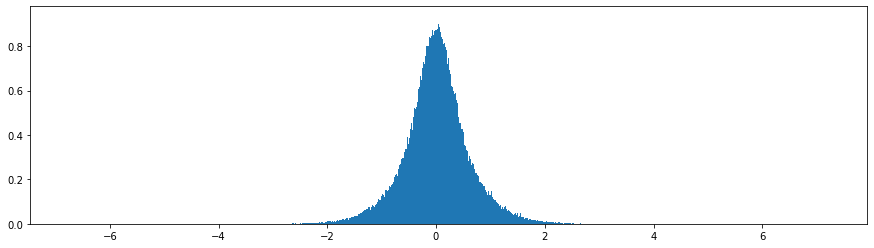

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.hist(lstm_l1_weights[0].reshape([-1]), bins=3000, density=True);
# plt.yscale('symlog', linthreshy=0.01)
plt.show();

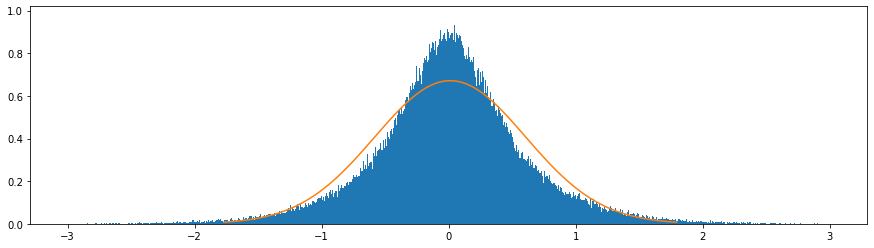

In [114]:
from scipy.stats import norm

sorted_weights = sorted(lstm_l1_weights[0].reshape([-1]))
sorted_weights = [w for w in sorted_weights if -3 < w < 3]
mu, sigma = norm.fit(sorted_weights, loc=0)

plt.figure(figsize=(15, 4))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(sorted_weights, bins=3000, density=True);
plt.plot(x, norm.pdf(x, mu, sigma))
plt.show();

(4.388757432176327, -0.018675635798551964, 0.45673142374327336)


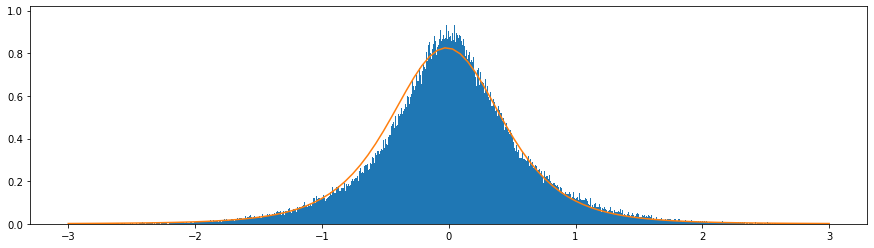

In [123]:
from scipy.stats import t

sorted_weights = sorted(lstm_l1_weights[0].reshape([-1]))
sorted_weights = [w for w in sorted_weights if -3 < w < 3]
params = t.fit(sorted_weights)
print(params)

plt.figure(figsize=(15, 4))
x = np.linspace(-3, 3, 100)
plt.hist(sorted_weights, bins=3000, density=True);
plt.plot(x, t.pdf(x, 4.388757432176327, -0.018675635798551964, 0.45673142374327336))
plt.show();

In [139]:
from scipy.stats import t

def plot(matrix):
    weights = matrix.reshape([-1])
    params = t.fit(weights)

    plt.figure(figsize=(15, 4))
    xs = np.linspace(-3, 3, 1000)
    plt.hist(weights, bins=3000, density=True);
    plt.plot(xs, t.pdf(xs, *params))
    plt.show();

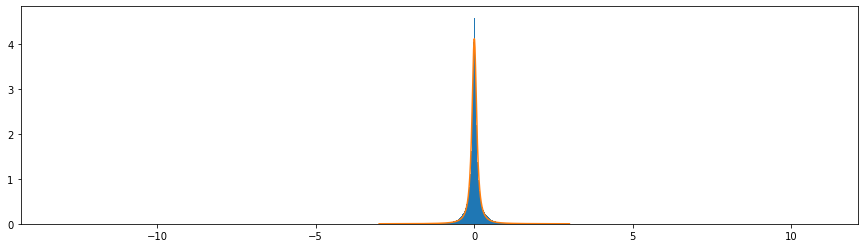

In [140]:
plot(lstm_l2_weights[1])

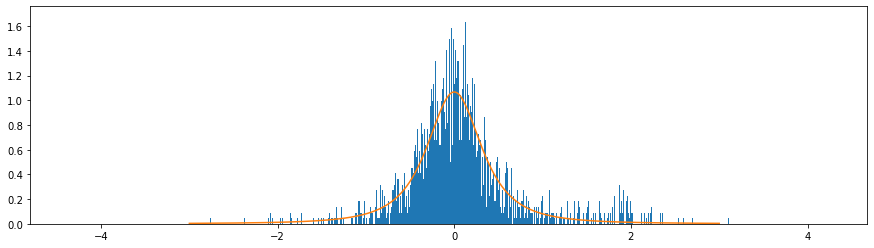

In [141]:
plot(lstm_l1_weights[2])

In [49]:
lstm_l2_weights = model.predicting_model.layers[3].get_weights()
lstm_l2_weights

[array([[-0.3283589 ,  0.09046551, -0.24412811, ..., -0.62480205,
         -0.27279717,  0.24514264],
        [ 0.06914138, -0.4823437 , -0.07496433, ..., -0.726358  ,
         -0.5257265 , -0.04378921],
        [-0.43972406, -0.31468207, -0.2820234 , ..., -0.40510908,
          0.09514338, -0.16105802],
        ...,
        [ 0.21945599,  0.39580676,  0.0308653 , ..., -0.32669985,
          0.24164397,  0.6604672 ],
        [ 0.16356482,  0.09557074,  0.13882168, ...,  0.27080232,
         -0.11237041,  0.4247634 ],
        [-0.15497734,  0.04157725, -0.06504079, ..., -0.04206531,
          0.09326441,  0.00332919]], dtype=float32),
 array([[-0.20036785,  0.38682827,  0.03189284, ..., -0.0163867 ,
          0.06271102, -0.28188768],
        [-0.01363384,  0.02853655, -0.00309315, ...,  0.14795877,
          0.10837564,  0.20546535],
        [ 0.06886893, -0.14185628, -0.04384421, ..., -0.08090531,
          0.09476643, -0.09233623],
        ...,
        [-0.05540706, -0.09691774,  0.0

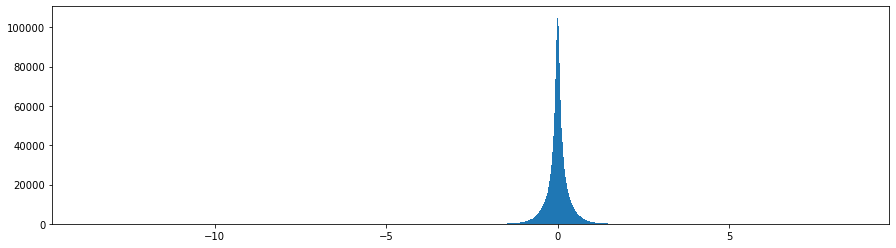

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.hist(lstm_l2_weights[0].reshape([-1]), bins=3000);

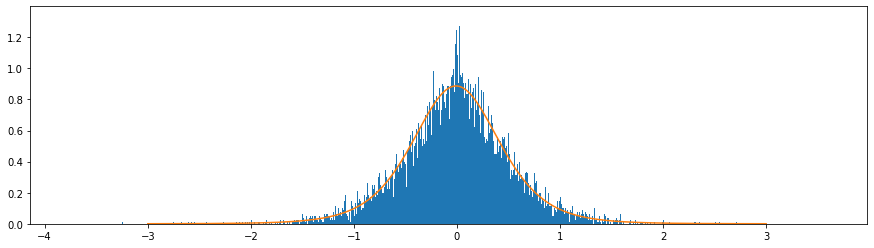

In [142]:
l1_weights = model.predicting_model.layers[1].get_weights()[0]

plot(l1_weights);

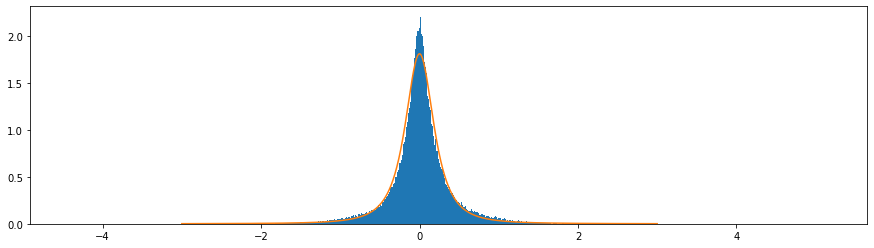

In [143]:
l4_weights = model.predicting_model.layers[4].get_weights()[0]

plot(l4_weights);

In [148]:
len(set(lstm_l1_weights[1].reshape([-1])))

4761793

## Теглата имат конкретно разпределение. Вероятно могат да бъдат ентропийно кодирани...